Environment Setup

In [22]:
# !pip install --quiet torch torchvision timm transformers scipy matplotlib

import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from scipy.io import loadmat
from tqdm import tqdm

from matplotlib import pyplot as plt
epoch_num=100
patience = 10
num_workers = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Dataset Download and Preparation

In [23]:
# !wget -q https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
# !wget -q https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
# !wget -q https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat

# !tar -xzf 102flowers.tgz

labels_mat = loadmat('imagelabels.mat')
labels = labels_mat['labels'][0]

split_mat = loadmat('setid.mat')
train_idx = split_mat['trnid'][0] - 1
val_idx   = split_mat['valid'][0] - 1
test_idx  = split_mat['tstid'][0] - 1

image_files = sorted([os.path.join('jpg', f) for f in os.listdir('jpg') if f.endswith('.jpg')])
assert len(image_files) == len(labels)

print("First image:", image_files[0], "Label:", labels[0])

First image: jpg/image_00001.jpg Label: 77


We use data augmentation for SimCLR (random crops, flips, color jitter, etc.). For classification we use simple resizing and normalization. (The image mean/std are assumed ImageNet-like.)

In [24]:
# Transforms for SimCLR augmentations (two random views)
simclr_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.8,0.8,0.8,0.2)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Transforms for linear evaluation (resized center crop)
cls_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

Define datasets:
For SimCLR (unsupervised): return two augmented views of each image.
For classification (supervised): return image tensor and label for training/testing the classifier.

In [28]:
class SimCLRDataset(Dataset):
    def __init__(self, files, transform):
        self.files = files
        self.transform = transform
        self.loader = default_loader
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = self.loader(self.files[idx]).convert('RGB')
        # Two random augmented views
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

class ImageLabelDataset(Dataset):
    def __init__(self, files, labels, transform):
        self.files = files
        self.labels = labels
        self.transform = transform
        self.loader = default_loader
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = self.loader(self.files[idx]).convert('RGB')
        img = self.transform(img)
        label = int(self.labels[idx] - 1)  # 0-index classes
        return img, label

# Prepare datasets
# Use all images for unsupervised SimCLR
simclr_dataset = SimCLRDataset(image_files, simclr_transform)
# For evaluation, use train/val as training data (combined) and test for testing
train_files = [image_files[i] for i in np.concatenate([train_idx, val_idx])]
train_labels = [labels[i] for i in np.concatenate([train_idx, val_idx])]
test_files = [image_files[i] for i in test_idx]
test_labels = [labels[i] for i in test_idx]

train_dataset = ImageLabelDataset(train_files, train_labels, cls_transform)
test_dataset  = ImageLabelDataset(test_files, test_labels, cls_transform)

1. Contrastive Learning (SimCLR)

In [5]:
# Define SimCLR model: ResNet-18 encoder + MLP projection head
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self, base_encoder, dim=128):
        super().__init__()
        # Remove the original fully connected layer
        self.encoder = base_encoder
        self.encoder.fc = nn.Identity()
        feat_dim = 512  # output dimension of ResNet-18
        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, dim)
        )
    def forward(self, x):
        h = self.encoder(x)         # features (batch x 512)
        z = self.projector(h)       # projection (batch x dim)
        return h, z

# Instantiate model
base_resnet = models.resnet18(pretrained=True)
simclr_model = SimCLR(base_resnet, dim=128).to(device)

/home/lzqhzo/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lzqhzo/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lzqhzo/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.06MB/s]


Train using the NT-Xent loss. We concatenate the two views in the batch and compute a 2N×2N similarity matrix. The positive pair for image i is the other view of the same image. We use CrossEntropyLoss by masking out self-similarity and setting the target of each example to its positive pair index. Temperature is set to 0.5.

Epoch 001  Train Contrastive Loss: 4.5440


Epoch 002  Train Contrastive Loss: 4.5424


Epoch 003  Train Contrastive Loss: 4.5356


Epoch 004  Train Contrastive Loss: 4.5376


Epoch 005  Train Contrastive Loss: 4.5428


Epoch 006  Train Contrastive Loss: 4.5383


Epoch 007  Train Contrastive Loss: 4.5379


Epoch 008  Train Contrastive Loss: 4.5347


Epoch 009  Train Contrastive Loss: 4.5390


Epoch 010  Train Contrastive Loss: 4.5298


Epoch 011  Train Contrastive Loss: 4.5273


Epoch 012  Train Contrastive Loss: 4.5340


Epoch 013  Train Contrastive Loss: 4.5287


Epoch 014  Train Contrastive Loss: 4.5313


Epoch 015  Train Contrastive Loss: 4.5296


Epoch 016  Train Contrastive Loss: 4.5279


Epoch 017  Train Contrastive Loss: 4.5247


Epoch 018  Train Contrastive Loss: 4.5286


Epoch 019  Train Contrastive Loss: 4.5266


Epoch 020  Train Contrastive Loss: 4.5282


Epoch 021  Train Contrastive Loss: 4.5259


Epoch 022  Train Contrastive Loss: 4.5268


Epoch 023  Train Contrastive Loss: 4.5270


Epoch 024  Train Contrastive Loss: 4.5249


Epoch 025  Train Contrastive Loss: 4.5230


Epoch 026  Train Contrastive Loss: 4.5255


Epoch 027  Train Contrastive Loss: 4.5290


Epoch 028  Train Contrastive Loss: 4.5194


Epoch 029  Train Contrastive Loss: 4.5229


Epoch 030  Train Contrastive Loss: 4.5197


Epoch 031  Train Contrastive Loss: 4.5160


Epoch 032  Train Contrastive Loss: 4.5203


Epoch 033  Train Contrastive Loss: 4.5148


Epoch 034  Train Contrastive Loss: 4.5140


Epoch 035  Train Contrastive Loss: 4.5190


Epoch 036  Train Contrastive Loss: 4.5185


Epoch 037  Train Contrastive Loss: 4.5209


Epoch 038  Train Contrastive Loss: 4.5226


Epoch 039  Train Contrastive Loss: 4.5194


Epoch 040  Train Contrastive Loss: 4.5206


Epoch 041  Train Contrastive Loss: 4.5147


Epoch 042  Train Contrastive Loss: 4.5182


Epoch 043  Train Contrastive Loss: 4.5147


Epoch 044  Train Contrastive Loss: 4.5199
Early stopping at epoch 44 (no improvement in last 10 epochs).
=== Best train loss 4.5140 at epoch 34 ===


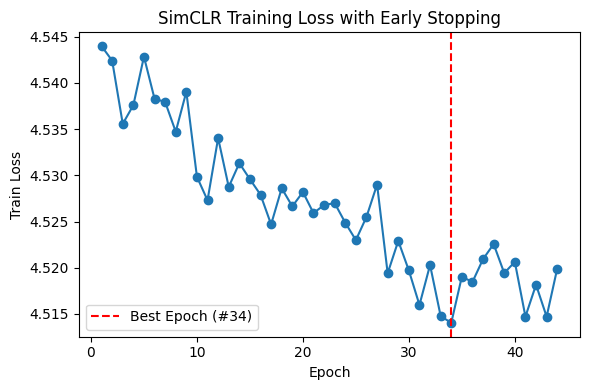

In [ ]:
# NT-Xent contrastive loss function

criterion_contrastive = nn.CrossEntropyLoss()
temperature = 0.5

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Compute NT-Xent loss between two sets of embeddings z1, z2 (of size N x dim).
    """
    N = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)          # 2N x dim
    z = F.normalize(z, dim=1)              # normalize embeddings
    sim = torch.matmul(z, z.T)             # similarity matrix (2N x 2N)
    # Mask out self-similarity
    mask = torch.eye(2*N, dtype=torch.bool, device=device)
    sim.masked_fill_(mask, -1e9)
    # Similarity scaled by temperature
    sim = sim / temperature
    # Targets: for i in [0,N), positive index is i+N; for i in [N,2N), positive is i-N
    targets = torch.cat([torch.arange(N, 2*N), torch.arange(0, N)]).long().to(device)
    loss = criterion_contrastive(sim, targets)
    return loss

# DataLoader for SimCLR (unsupervised)
simclr_loader = DataLoader(simclr_dataset, batch_size=256, shuffle=True, num_workers=num_workers)

# Optimizer
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=1e-4)


# Train SimCLR with early stopping
simclr_model.train()
best_loss = float('inf')      
best_epoch = -1
best_state = None
counter = 0

train_losses = []              

for epoch in range(1, epoch_num + 1):
    running_loss = 0.0
    # Training
    for (x1, x2) in tqdm(simclr_loader, desc=f"SimCLR Epoch {epoch}", leave=False):
        x1, x2 = x1.to(device), x2.to(device)
        _, z1 = simclr_model(x1)
        _, z2 = simclr_model(x2)
        loss = nt_xent_loss(z1, z2, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x1.size(0)

    avg_loss = running_loss / len(simclr_dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch:03d}  Train Contrastive Loss: {avg_loss:.4f}")

    # save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in simclr_model.state_dict().items()}
        counter = 0
    else:
        counter += 1
        # if the loss doesn't drop for 10 continuous epoches, early stopping
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in last {patience} epochs).")
            break

print(f"=== Best train loss {best_loss:.4f} at epoch {best_epoch} ===")

if best_state is not None:
    simclr_model.load_state_dict(best_state)

# plot losses
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.axvline(best_epoch, color='r', linestyle='--', label=f"Best Epoch (#{best_epoch})")
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('SimCLR Training Loss with Early Stopping')
plt.legend()
plt.tight_layout()
plt.show()

Once trained, we discard the projection head and keep the encoder (ResNet18) as the feature extractor. We now freeze the encoder and train a linear classifier on top (single-layer and a small 2-layer MLP) to evaluate the quality of the learned features. This is a common linear-probe evaluation. We use the frozen encoder to extract features and train on the 1020 training images.

In [29]:
# Linear and MLP classifiers on top of frozen ResNet features
class LinearClassifier(nn.Module):
    def __init__(self, feat_dim=512, num_classes=102):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)
    def forward(self, x): return self.fc(x)

class MLPClassifier(nn.Module):
    def __init__(self, feat_dim=512, num_classes=102):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.net(x)

# Feature extractor: output of encoder avgpool
def extract_resnet_features(model, images):
    # The SimCLR model's forward returns (features, projection). We only need features.
    h, _ = model(images)  # Call the SimCLR model's forward method
    return h

# # Prepare dataloaders for classification
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=num_workers)

In [ ]:
# Train and evaluate a linear classifier on SimCLR features
def train_classifier(encoder, classifier, train_loader, test_loader, epochs=100):
    device = next(encoder.parameters()).device 
    classifier = classifier.to(device)

    # frozen the entire simclr_model
    encoder.eval()
    for param in encoder.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_epoch = -1
    best_state_dict = None
    counter = 0 

    for epoch in range(1, epochs + 1):
        # Training
        classifier.train()
        running_loss = 0.0
        running_total = 0

        for imgs, labs in train_loader:
            imgs = imgs.to(device)
            labs = labs.to(device)

            with torch.no_grad():
                feat_proj = encoder(imgs)
                feats = feat_proj[0]

            logits = classifier(feats)
            loss = criterion(logits, labs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labs.size(0)
            running_total += labs.size(0)

        avg_train_loss = running_loss / running_total
        train_losses.append(avg_train_loss)

        # Validating
        classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labs in test_loader:
                imgs = imgs.to(device)
                labs = labs.to(device)

                feat_proj = encoder(imgs)
                feats = feat_proj[0]

                preds = classifier(feats).argmax(dim=1)
                correct += (preds == labs).sum().item()
                total += labs.size(0)

        val_acc = correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch}/{epochs}]  Train Loss: {avg_train_loss:.4f}  |  Val Acc: {val_acc:.4f}")

        # save the best model in validating
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state_dict = {k: v.cpu().clone() for k, v in classifier.state_dict().items()}
            counter = 0
        else:
            counter += 1
            # if the loss doesn't drop for 10 continuous epoches, early stopping
            if counter >= patience:
                print(f"Early stopping at epoch {epoch} (no improvement in last {patience} epochs).")
                break

    print(f"=== Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch} ===")
    return train_losses, val_accuracies, best_epoch, best_state_dict

# Linear probe
linear_cls = LinearClassifier(feat_dim=512, num_classes=102)
train_losses_lin, val_accuracies_lin, best_epoch_lin, best_state_dict_lin = train_classifier(simclr_model, linear_cls, train_loader, test_loader, epochs=epoch_num)


# MLP probe
mlp_cls = MLPClassifier(feat_dim=512, num_classes=102)
train_losses_mlp, val_accuracies_mlp, best_epoch_mlp, best_state_dict_mlp = train_classifier(simclr_model, mlp_cls, train_loader, test_loader, epochs=epoch_num)


Epoch [1/100]  Train Loss: 2.7909  |  Val Acc: 0.7657
Epoch [2/100]  Train Loss: 0.9448  |  Val Acc: 0.8486
Epoch [3/100]  Train Loss: 0.6409  |  Val Acc: 0.8735
Epoch [4/100]  Train Loss: 0.5132  |  Val Acc: 0.8759
Epoch [5/100]  Train Loss: 0.4285  |  Val Acc: 0.8919
Epoch [6/100]  Train Loss: 0.3725  |  Val Acc: 0.8920
Epoch [7/100]  Train Loss: 0.3270  |  Val Acc: 0.8985
Epoch [8/100]  Train Loss: 0.2880  |  Val Acc: 0.8956
Epoch [9/100]  Train Loss: 0.2585  |  Val Acc: 0.9008
Epoch [10/100]  Train Loss: 0.2380  |  Val Acc: 0.9018
Epoch [11/100]  Train Loss: 0.2127  |  Val Acc: 0.9018
Epoch [12/100]  Train Loss: 0.1966  |  Val Acc: 0.9008
Epoch [13/100]  Train Loss: 0.1797  |  Val Acc: 0.9071
Epoch [14/100]  Train Loss: 0.1673  |  Val Acc: 0.9026
Epoch [15/100]  Train Loss: 0.1566  |  Val Acc: 0.9036
Epoch [16/100]  Train Loss: 0.1404  |  Val Acc: 0.9086
Epoch [17/100]  Train Loss: 0.1345  |  Val Acc: 0.9071
Epoch [18/100]  Train Loss: 0.1236  |  Val Acc: 0.9071
Epoch [19/100]  Tra

SimCLR Linear probe accuracy: 91.2%
SimCLR MLP classifier accuracy: 90.6%


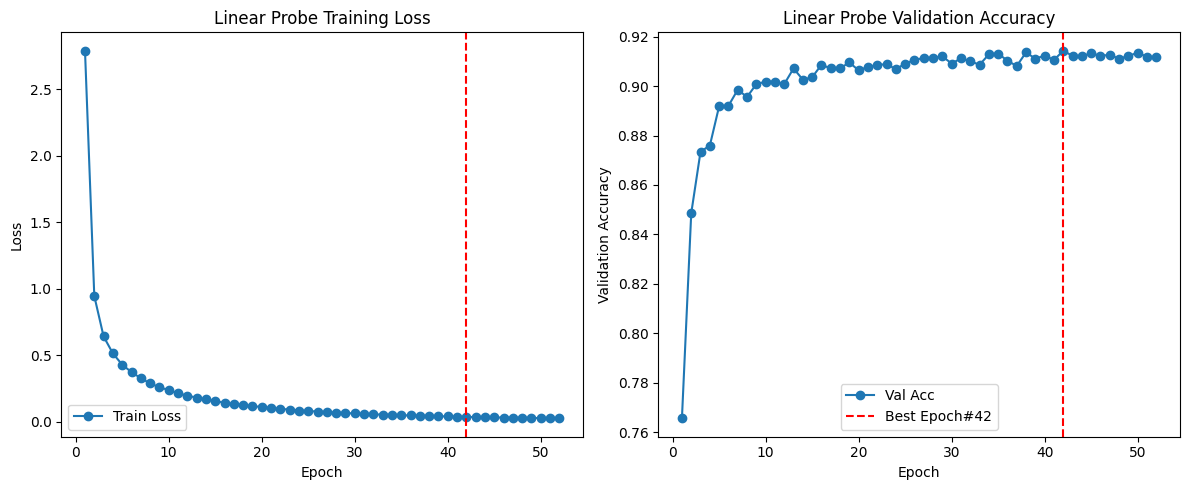

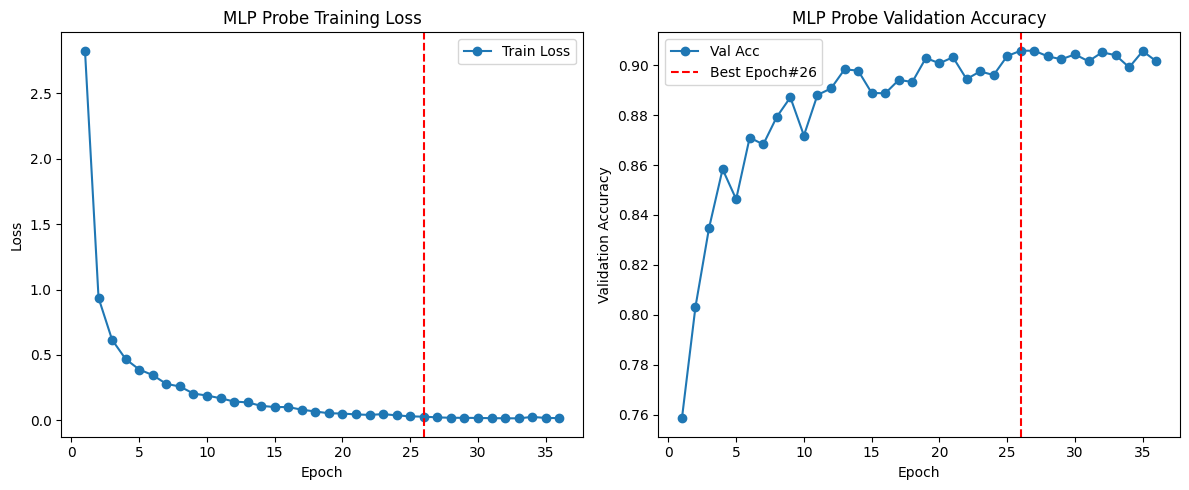

In [18]:
print(f"SimCLR Linear probe accuracy: {val_accuracies_lin[best_epoch_lin]*100:.1f}%")
print(f"SimCLR MLP classifier accuracy: {val_accuracies_mlp[best_epoch_mlp]*100:.1f}%")

epochs_lin = range(1, len(train_losses_lin) + 1)
epochs_mlp = range(1, len(train_losses_mlp) + 1)

# Linear Probing
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_lin, train_losses_lin, marker='o', label='Train Loss')
plt.axvline(best_epoch_lin, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Linear Probe Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_lin, val_accuracies_lin, marker='o', label='Val Acc')
plt.axvline(best_epoch_lin, color='r', linestyle='--',label=f'Best Epoch#{best_epoch_lin}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Linear Probe Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# MLP
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_mlp, train_losses_mlp, marker='o', label='Train Loss')
plt.axvline(best_epoch_mlp, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Probe Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_mlp, val_accuracies_mlp, marker='o', label='Val Acc')
plt.axvline(best_epoch_mlp, color='r', linestyle='--',label=f'Best Epoch#{best_epoch_mlp}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('MLP Probe Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

2. Masked Autoencoder (MAE)

Construct the MAE model

In [10]:
from transformers import ViTMAEForPreTraining, AutoImageProcessor

torch.cuda.empty_cache()

# Load a pre-trained ViT-MAE model (base, patch16) from Hugging Face
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
mae_model.train().to(device)

# Image processor for MAE: handles patch embedding, normalization, etc.
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")

# Dataset for MAE (we'll use the same images list, as unlabeled data)
class PILImageDataset(Dataset):
    def __init__(self, files):
        self.files = files
        self.loader = default_loader
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = self.loader(self.files[idx]).convert('RGB')
        return img

mae_dataset = PILImageDataset(image_files)
mae_loader = DataLoader(mae_dataset, batch_size=64, shuffle=True, num_workers=num_workers, collate_fn=lambda x: list(x))

optimizer_mae = torch.optim.AdamW(mae_model.parameters(), lr=1e-4)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Training MAE: At each step, the processor randomly masks patches and returns tensors. The MAE model's forward pass returns loss which compares reconstructed pixels with the original (unmasked) ones. 

In [ ]:
# Train MAE
train_losses = []
best_loss = float('inf')
best_epoch = -1
best_state = None
counter = 0
for epoch in range(20):
    total_loss = 0.0
    for imgs in tqdm(mae_loader, desc=f"MAE Epoch {epoch+1}", leave=False):
        # imgs is a list of PIL images
        inputs = processor(images=imgs, return_tensors="pt").to(device)
        outputs = mae_model(**inputs)
        loss = outputs.loss  # MAE reconstruction loss
        optimizer_mae.zero_grad()
        loss.backward()
        optimizer_mae.step()
        total_loss += loss.item() * len(imgs)
    avg_loss = total_loss / len(mae_dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} MAE Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in mae_model.state_dict().items()}
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

print(f"Best MAE Loss: {best_loss:.4f} at epoch {best_epoch}")

if best_state is not None:
    mae_model.load_state_dict(best_state)
    
# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.axvline(best_epoch, color='r', linestyle='--', label=f"Best Epoch #{best_epoch+1}")
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE Training Loss with Early Stopping')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1 MAE Loss: 0.2779


Epoch 2 MAE Loss: 0.2754


Epoch 3 MAE Loss: 0.2757


Epoch 4 MAE Loss: 0.2733


Epoch 5 MAE Loss: 0.2722


Epoch 6 MAE Loss: 0.2710


Epoch 7 MAE Loss: 0.2711


Epoch 8 MAE Loss: 0.2696


Epoch 9 MAE Loss: 0.2686


Epoch 10 MAE Loss: 0.2675


Epoch 11 MAE Loss: 0.2665


Epoch 12 MAE Loss: 0.2656


Epoch 13 MAE Loss: 0.2653


Epoch 14 MAE Loss: 0.2647


Epoch 15 MAE Loss: 0.2634


Epoch 16 MAE Loss: 0.2618


Epoch 17 MAE Loss: 0.2621


Epoch 18 MAE Loss: 0.2610


Epoch 19 MAE Loss: 0.2608


Epoch 20 MAE Loss: 0.2599
Best MAE Loss: 0.2599 at epoch 20


After training, we discard the decoder and use the ViT encoder. We extract the [CLS] token embedding (from last_hidden_state[:,0]) as a feature vector for each image. We freeze the ViT parameters and again train a linear and an MLP classifier on these features.

In [ ]:
# Freeze MAE model encoder for linear probe
mae_model.eval()
for p in mae_model.parameters():
    p.requires_grad = False

# Define feature extractor using MAE encoder
def extract_mae_features(model, processor, images):
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        # Access the encoder part of the MAE model
        outputs = model.vit(**inputs)
    # ViT [CLS] token embedding
    feats = outputs.last_hidden_state[:, 0]
    return feats

# Prepare DataLoader for classification using processor inside loop
train_loader_mae = DataLoader(train_files, batch_size=16, shuffle=True)
test_loader_mae  = DataLoader(test_files,  batch_size=32, shuffle=False)

# Train linear classifier on MAE features
linear_cls_mae = LinearClassifier(feat_dim=768, num_classes=102).to(device)
optimizer_lin_mae = torch.optim.Adam(linear_cls_mae.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    linear_cls_mae.train()
    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        # We actually need PIL images for processor, so we skip using train_loader here.
        pass

# Prepare feature extraction for MAE on training and test images
# We will process images batchwise through processor inside loop

# Convert file paths to PIL images on the fly
class PILDataLoader:
    def __init__(self, files, labels=None, batch_size=16, shuffle=False):
        self.files = files
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __iter__(self):
        indices = list(range(len(self.files)))
        if self.shuffle:
            random.shuffle(indices)
        for i in range(0, len(indices), self.batch_size):
            batch_idx = indices[i:i+self.batch_size]
            imgs = [default_loader(self.files[j]).convert('RGB') for j in batch_idx]
            if self.labels is not None:
                labs = torch.tensor([self.labels[j]-1 for j in batch_idx], dtype=torch.long)
                yield imgs, labs
            else:
                yield imgs

train_loader_mae = PILDataLoader(train_files, train_labels, batch_size=16, shuffle=True)
test_loader_mae  = PILDataLoader(test_files, test_labels, batch_size=32, shuffle=False)

# Linear classifier for MAE features (hidden size = 768 for ViT-base)
linear_cls_mae = LinearClassifier(feat_dim=768, num_classes=102).to(device)
optimizer_lin_mae = torch.optim.Adam(linear_cls_mae.parameters(), lr=1e-3)

for epoch in range(5):
    linear_cls_mae.train()
    for imgs, labs in train_loader_mae:
        feats = extract_mae_features(mae_model, processor, imgs)  # [batch,768]
        feats = feats.to(device)
        labs = labs.to(device)
        logits = linear_cls_mae(feats)
        loss = criterion(logits, labs)
        optimizer_lin_mae.zero_grad()
        loss.backward()
        optimizer_lin_mae.step()

# Evaluate linear probe
linear_cls_mae.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labs in test_loader_mae:
        feats = extract_mae_features(mae_model, processor, imgs).to(device)
        labs = labs.to(device)
        preds = linear_cls_mae(feats).argmax(dim=1)
        correct += (preds == labs).sum().item()
        total += labs.size(0)
print(f"MAE Linear probe accuracy: {100*correct/total:.1f}%")

# MLP classifier for MAE features
mlp_cls_mae = MLPClassifier(feat_dim=768, num_classes=102).to(device)
optimizer_mlp_mae = torch.optim.Adam(mlp_cls_mae.parameters(), lr=1e-3)

for epoch in range(5):
    mlp_cls_mae.train()
    for imgs, labs in train_loader_mae:
        feats = extract_mae_features(mae_model, processor, imgs).to(device)
        labs = labs.to(device)
        logits = mlp_cls_mae(feats)
        loss = criterion(logits, labs)
        optimizer_mlp_mae.zero_grad()
        loss.backward()
        optimizer_mlp_mae.step()

# Evaluate MLP probe
mlp_cls_mae.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labs in test_loader_mae:
        feats = extract_mae_features(mae_model, processor, imgs).to(device)
        labs = labs.to(device)
        preds = mlp_cls_mae(feats).argmax(dim=1)
        correct += (preds == labs).sum().item()
        total += labs.size(0)
print(f"MAE MLP classifier accuracy: {100*correct/total:.1f}%")

MAE Linear probe accuracy: 48.1%
MAE MLP classifier accuracy: 47.9%
